In [2]:
!pip install torch torchvision

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [23]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import cv2

def cam(features, outputs, model, idx):
    bz, nc, h, w = features.size()
    features_new = features.view(bz, nc, h*w)

    probs, idxs = outputs.sort(1, True)
    class_idx = idxs[:, 0]
    w = model.fc1.weight[class_idx].unsqueeze(1)
    cam = torch.bmm(w , features_new)

    attentionMap = nn.Softmax(dim=1)(cam.squeeze(1))
    attentionMap = attentionMap.view(attentionMap.size(0), 1, 7, 7)
    attentionMap = attentionMap.data.cpu().numpy()
    img = images[idx][0]
    img = np.asarray(img)
    img = np.stack((img,img,img), axis=2)
    attentionMap = attentionMap[idx].reshape(7, 7)
    attentionMap = attentionMap - np.min(attentionMap)
    attentionMap = attentionMap / np.max(attentionMap)
    attentionMap = np.uint8(255 * attentionMap)
    attentionMap = cv2.resize(attentionMap, (28, 28))
    heatmap = cv2.applyColorMap(attentionMap, cv2.COLORMAP_JET)
    attentionMap_overlay = heatmap * 0.3 + img * 0.5
    attentionMap_overlay = cv2.cvtColor(np.uint8(attentionMap_overlay), cv2.COLOR_RGB2BGR)

    fig = plt.figure
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.imshow(attentionMap_overlay, cmap='gray')
    plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 64



In [5]:
# Download and prepare MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_training = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.2),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_training, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 72545932.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24097014.88it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 29650759.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3475739.60it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dp = nn.Dropout(p = 0.4)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        features = x
        x = self.avg_pool(x)
        x = x.view(-1, 128)
        x = self.dp(x)
        x = self.relu(self.fc1(x))
        return x, features


In [13]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs, _ = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print('Training complete!')

Epoch [1/10], Step [100/938], Loss: 0.0663
Epoch [1/10], Step [200/938], Loss: 0.2275
Epoch [1/10], Step [300/938], Loss: 0.1601
Epoch [1/10], Step [400/938], Loss: 0.3072
Epoch [1/10], Step [500/938], Loss: 0.1692
Epoch [1/10], Step [600/938], Loss: 0.1605
Epoch [1/10], Step [700/938], Loss: 0.0744
Epoch [1/10], Step [800/938], Loss: 0.0922
Epoch [1/10], Step [900/938], Loss: 0.1081
Epoch [2/10], Step [100/938], Loss: 0.1253
Epoch [2/10], Step [200/938], Loss: 0.1419
Epoch [2/10], Step [300/938], Loss: 0.0932
Epoch [2/10], Step [400/938], Loss: 0.0448
Epoch [2/10], Step [500/938], Loss: 0.1283


KeyboardInterrupt: ignored

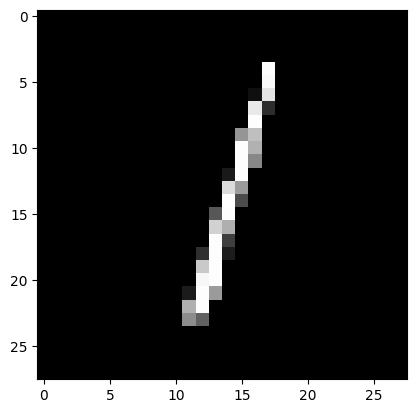

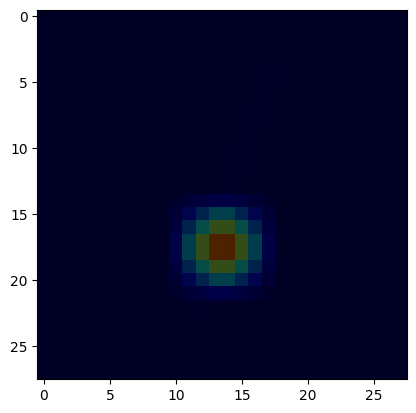

Accuracy on the test set: 96.55%


In [29]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs, features = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if idx == 0:
          cam(features, outputs, model, 2)


accuracy = correct / total
print(f'Accuracy on the test set: {100 * accuracy:.2f}%')